# **Import Libraries**

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install tensorflowjs

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import shutil
from shutil import copyfile
import opendatasets as od
from PIL import Image

#import tensorflowjs as tfjs
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt

import time

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# **Download dan import datasets**

In [ ]:
! chmod 600 /root/kaggle.json

chmod: cannot access '/root/kaggle.json': No such file or directory


In [ ]:
# Mendownload datasets dari kaggle 
od.download("https://www.kaggle.com/datasets/fabinahian/plant-disease-45-classes")
od.download("https://www.kaggle.com/datasets/lijiyu/imagenet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wicklygusthvi
Your Kaggle Key: ··········


100%|██████████| 3.00G/3.00G [00:44<00:00, 72.9MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wicklygusthvi
Your Kaggle Key: ··········


100%|██████████| 6.21G/6.21G [01:12<00:00, 91.5MB/s]


# **Gabung datasets**

In [ ]:
name_classes = ("leaf", "not_leaf")
datasets_dir = '/content/data/'

In [ ]:
shutil.rmtree(datasets_dir, ignore_errors=True)

os.mkdir(datasets_dir)
for name in name_classes:
  os.mkdir(os.path.join(datasets_dir, name))

In [ ]:
base_source_dir = "/content/plant-disease-45-classes/Plant World"
target_dir = "/content/data/leaf"
class_dir = os.listdir(base_source_dir)
class_dir.sort()

In [ ]:
for index, value in enumerate(class_dir):
  dest_dir = target_dir
  source_dir = os.path.join(base_source_dir, value)
  list_data = os.listdir(source_dir)

  for data in list_data:
    source = os.path.join(source_dir, data)
    dest = os.path.join(dest_dir, data)
    shutil.copy(source, dest)

In [ ]:
base_source_dir = "/content/imagenet/imagenet"
target_dir = "/content/data/not_leaf"
class_dir = os.listdir(base_source_dir)
class_dir.sort()

In [ ]:
for index, value in enumerate(class_dir):
  dest_dir = target_dir
  source_dir = os.path.join(base_source_dir, value)
  list_data = os.listdir(source_dir)

  for data in list_data:
    source = os.path.join(source_dir, data)
    dest = os.path.join(dest_dir, data)
    shutil.copy(source, dest)

In [ ]:
total_data = 0
for folder_path in os.listdir("/content/data"):
  length_data = len(os.listdir("/content/data/{}".format(folder_path)))
  total_data = total_data + length_data
  print(folder_path, length_data)

print("Total data:", total_data)

leaf 56809
not_leaf 50000
Total data: 106809


In [ ]:
all_files = os.listdir('/content/data/leaf')

if len(all_files) > 50000:
    selected_files = random.sample(all_files, 50000)
else:
    selected_files = all_files

for file_name in all_files:
    if file_name not in selected_files:
        file_path = os.path.join('/content/data/leaf', file_name)
        os.remove(file_path)

In [ ]:
directories = ['/content/data/not_leaf', '/content/data/leaf']
file_lists = [[os.path.join(d, f) for f in os.listdir(d)] for d in directories]

for files in file_lists:
    print(len(files))

50000
50000


# **Split Data**

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_files = []
val_files = []
test_files = []

for files in file_lists:
    random.shuffle(files)  # Shuffle the files in each directory
    num_train = int(len(files) * train_ratio)
    num_val = int(len(files) * val_ratio)
    
    train_files.append(files[:num_train])
    val_files.append(files[num_train:num_train+num_val])
    test_files.append(files[num_train+num_val:])
    
print(f'Total training files: {sum([len(files) for files in train_files])}')
print(f'Total validation files: {sum([len(files) for files in val_files])}')
print(f'Total test files: {sum([len(files) for files in test_files])}')

Total training files: 80000
Total validation files: 10000
Total test files: 10000


In [ ]:
train_dir = '/content/train'  # path folder baru untuk data train
val_dir = '/content/validation'  # path folder baru untuk data validation
test_dir = '/content/test'  # path folder baru untuk data test

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for files in train_files:
    label = os.path.basename(os.path.dirname(files[0]))  # ambil nama direktori sebagai label/nama folder
    label_dir = os.path.join(train_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

for files in val_files:
    label = os.path.basename(os.path.dirname(files[0]))  # ambil nama direktori sebagai label/nama folder
    label_dir = os.path.join(val_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

for files in test_files:
    label = os.path.basename(os.path.dirname(files[0]))  # ambil nama direktori sebagai label/nama folder
    label_dir = os.path.join(test_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

In [ ]:
directories_to_delete = [
    "/content/imagenet",
    "/content/plant-disease-45-classes"
]

for directory in directories_to_delete:
    shutil.rmtree(directory, ignore_errors=True)

# **Visualisasi Data**

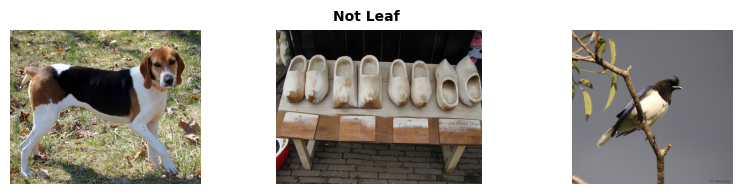

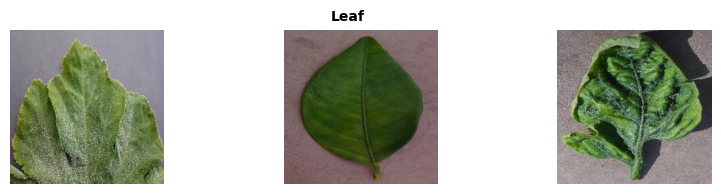

In [ ]:
labels = ['Not Leaf' ,'Leaf']

def display_images(train_dir, label, num_images=3):
    plt.figure(figsize=(10,2))
    plt.suptitle(label, fontsize=10, fontweight='bold')
    for i in range(num_images):
        image_path = os.path.join(train_dir, random.choice(os.listdir(base_dir)))
        image = plt.imread(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Display sample images from each directory
for i, base_dir in enumerate(directories):
    display_images(base_dir, labels[i])

# **Augmentasi Data**

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 100

In [ ]:
datagen = ImageDataGenerator(rescale=1./255.)

# Load dataset from directory
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 79999 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


# **Latih Model**

## MobileNet

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)

model_mobilenet = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDetection_MobileNet")

model_mobilenet.summary()

Model: "LeafDetection_MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2

In [ ]:
opt = Adam(learning_rate = 0.001)

model_mobilenet.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
hist_mobilenet = model_mobilenet.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 5,
                    batch_size = BATCH_SIZE,
                    verbose=1
                    )

Epoch 1/5
800/800 [==============================] - 827s 1s/step - loss: 0.0358 - accuracy: 0.9879 - val_loss: 0.0081 - val_accuracy: 0.9978
Epoch 2/5
800/800 [==============================] - 808s 1s/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0054 - val_accuracy: 0.9987
Epoch 3/5
800/800 [==============================] - 768s 959ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0044 - val_accuracy: 0.9986
Epoch 4/5
800/800 [==============================] - 761s 951ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0037 - val_accuracy: 0.9989
Epoch 5/5
800/800 [==============================] - 761s 951ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0037 - val_accuracy: 0.9990


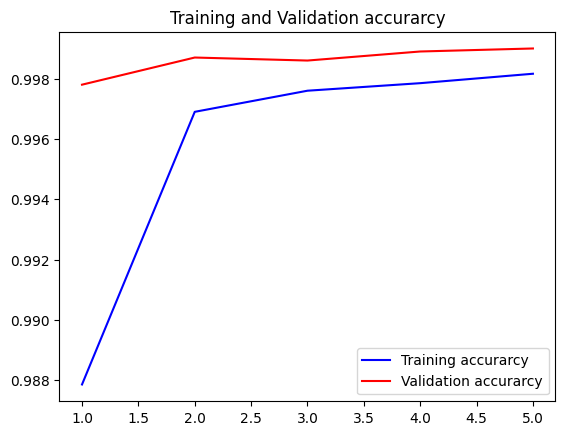

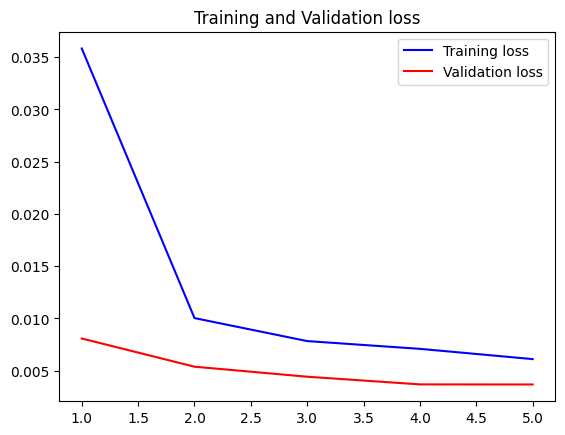

In [ ]:
acc = hist_mobilenet.history['accuracy']
val_acc = hist_mobilenet.history['val_accuracy']
loss = hist_mobilenet.history['loss']
val_loss = hist_mobilenet.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Classification Report

In [ ]:
def create_classification_report(nama_model):
    y_pred = nama_model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(8, 6), dpi=100)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

## MobileNet

100/100 [==============================] - 86s 862ms/step


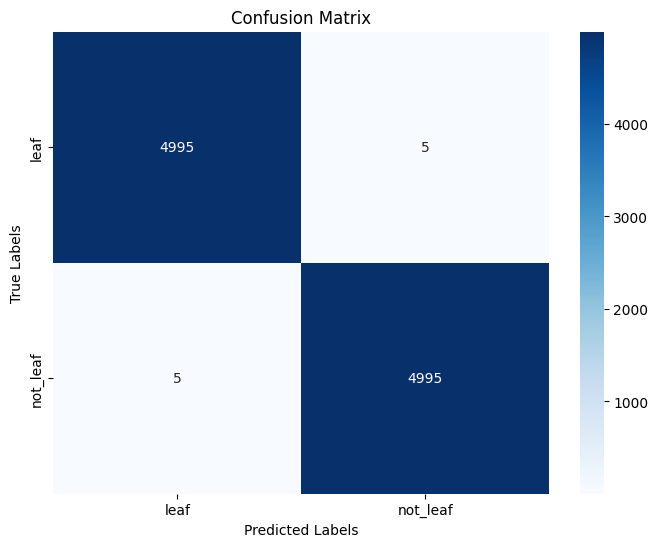

              precision    recall  f1-score   support

        leaf       1.00      1.00      1.00      5000
    not_leaf       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
create_classification_report(model_mobilenet)

In [ ]:
val_generator.class_indices.keys()

dict_keys(['leaf', 'not_leaf'])

# **Test Data Baru**

In [ ]:
# Mengunggah gambar

uploaded = files.upload()

class_names = list(val_generator.class_indices.keys())

for fn in uploaded.keys():
  # Memuat gambar dan mengubah ukurannya
  path = fn
  image = np.array(Image.open(path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE)))
  image = image / 255
  img_array = tf.expand_dims(image, 0)

  # Prediksi gambar menggunakan model
  classes = model_mobilenet.predict(img_array)

  predicted_class_index = np.argmax(classes)
  predicted_class = class_names[predicted_class_index]
  confidence_level = classes[0][predicted_class_index] * 100

  print(fn)
  print("Gambar ini adalah", predicted_class)
  print("Confidence:", confidence_level, "%")

Saving applescableaf51.jpeg to applescableaf51.jpeg
1/1 [==============================] - 0s 26ms/step
applescableaf51.jpeg
Gambar ini adalah leaf
Confidence: 99.77989792823792 %


# Save model

In [ ]:
model_mobilenet.save("content/leaf.h5")